In [1]:
import os
import glob
import pathlib
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Extracting files


In [3]:
def extract_files(folder_path):
    csv_files = glob.glob(os.path.join(folder_path, "*.csv"))
    dataframes = []

    for file in csv_files:
        df = pd.read_csv(file)
        dataframes.append(df)
    return dataframes


extracted = extract_files("/content/drive/MyDrive/Topic_modelling")

In [4]:
alldata = pd.DataFrame()
for listitems in extracted:
    alldata = pd.concat([alldata, listitems])

## Feature extraction

In [5]:
alldata.head()

,headlines,description,content,url,category
0,CUET PG 2024: Register with NTA to enable admi...,CUET PG 2024: UGC said that the list of partic...,The Common University Entrance Test Postgradua...,https://indianexpress.com/article/education/cu...,education
1,Oxford ends ties with TCS iON over technical g...,"On April 10, 2023 TCS had announced that it ha...",Less than a year after the Oxford University s...,https://indianexpress.com/article/education/ox...,education
2,"Enrollments in Computer Engineering surge, mec...",AISHE Report 2021-22: The enrollment in STEM (...,Student enrollments in Computer Engineering ha...,https://indianexpress.com/article/education/en...,education
3,"NDMC plans to provide free JEE, NEET UG coachi...",The coaching partner will also provide up-to-d...,The New Delhi Municipal Council (NDMC) is invi...,https://indianexpress.com/article/education/nd...,education
4,"BA courses register highest enrollment, maximu...",AISHE Report 2021-22: For programmes including...,Bachelor of Arts (BA) courses had the highest ...,https://indianexpress.com/article/education/ba...,education


In [6]:
targets = alldata["category"]
feature = alldata["content"]

In [7]:
print(targets.unique())

['education' 'business' 'entertainment' 'sports' 'technology']


In [7]:
VALIDATION_SPLIT = 0.25
TRAIN_SPLIT = 0.8

nb_training_samples = int(TRAIN_SPLIT * feature.shape[0])
nb_validation_samples = int(VALIDATION_SPLIT * feature.shape[0])

#Train/Test sets
x_train, x_test = feature[:nb_training_samples], feature[nb_training_samples:]
y_train, y_test = targets[:nb_training_samples], targets[nb_training_samples:]

# validation sets
x_valid = x_train[-nb_validation_samples:]
y_valid = y_train[-nb_validation_samples:]

In [89]:
maxlen = 100
embedding_dim = 100
max_words = 10000

classnames = {
    0 : 'Business',
    1 : 'Education',
    2 : 'Entertainment',
    3 : 'Sports',
    4 : 'Technology'
}

### Prepare pretained word embeddings

In [94]:
embeddings_index = {}
f = open('glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype="float32")
    embeddings_index[word] = coefs
f.close()

print('found %s word vectors.' % len(embeddings_index))

found 400000 word vectors.


In [95]:
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [96]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_scheduler = keras.callbacks.LearningRateScheduler(scheduler)

In [97]:
my_callbacks = [
    lr_scheduler,
    keras.callbacks.EarlyStopping(monitor="val_loss",
                                  patience=10, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                                      patience=10, min_lr=0.0001),
    keras.callbacks.ModelCheckpoint("model.keras", save_best_only=True)
]

### Using TfIDvectorizer

In [ ]:
labels1 = np.asarray(targets)
indices1 = np.arange(feature.shape[0])
np.random.shuffle(indices1)
labels1 = labels1[indices1]

In [ ]:
VALIDATION_SPLIT = 0.25
TRAIN_SPLIT = 0.7

nb_training_samples = int(TRAIN_SPLIT * feature.shape[0])
nb_validation_samples = int(VALIDATION_SPLIT * feature.shape[0])

#Train/Test sets
x_train_tf, x_test_tf = feature[:nb_training_samples], feature[nb_training_samples:]
y_train_tf, y_test_tf_real = labels1[:nb_training_samples], labels1[nb_training_samples:]

# validation sets
x_valid_tf = x_train_tf[-nb_validation_samples:]
y_valid_tf = y_train_tf[-nb_validation_samples:]

In [ ]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=10000)
tfidf_vectorizer.fit(x_train_tf)
x_train_tfid = tfidf_vectorizer.transform(x_train_tf)
x_test_tfid = tfidf_vectorizer.transform(x_test_tf)
x_valid_tfid = tfidf_vectorizer.transform(x_valid_tf)

#y_train_tfid = tf.keras.utils.to_categorical(y_train_tf)
#y_valid_tfid = tf.keras.utils.to_categorical(y_valid_tf)

In [ ]:
print(x_train_tfid.shape)
print(x_test_tfid.shape)
print(x_valid_tfid.shape)

NameError: name 'x_train_tfidf' is not defined

In [ ]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(y_train_tf)
y_train_tf = encoder.transform(y_train_tf)

In [ ]:
y_valid_tf = encoder.transform(y_valid_tf)
y_test_tf = encoder.transform(y_test_tf_real)
y_test_coms_tf = encoder.transform(y_test_tf_real)

In [ ]:
y_train_tfid = tf.keras.utils.to_categorical(y_train_tf)
y_valid_tfid = tf.keras.utils.to_categorical(y_valid_tf)

### Models with TFID Vectorizer


In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Embedding, Dense, Flatten, LSTM
from keras.layers import Conv1D, MaxPooling1D, Dropout

model_tifid = Sequential()
model_tifid.add(Embedding(input_dim=max_words, output_dim = embedding_dim,
                          embeddings_initializer = 'he_normal'))
model_tifid.add(Conv1D(64, 3, activation = 'relu'))
model_tifid.add(MaxPooling1D(5))
model_tifid.add(LSTM(32))
model_tifid.add(Flatten())
model_tifid.add(Dense(units=128, activation='relu'))
model_tifid.add(Dropout(0.5))
model_tifid.add(Dense(units=80, activation='relu'))
model_tifid.add(Dropout(0.5))
model_tifid.add(Dropout(0.5))
model_tifid.add(Dense(5, activation = 'softmax'))

model_tifid.summary()
model_tifid.save("model_tifid.keras")

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         1000000   
                                                                 
 conv1d (Conv1D)             (None, None, 64)          19264     
                                                                 
 max_pooling1d (MaxPooling1  (None, None, 64)          0         
 D)                                                              
                                                                 
 lstm (LSTM)                 (None, 32)                12416     
                                                                 
 flatten (Flatten)           (None, 32)                0         
                                                                 
 dense_9 (Dense)             (None, 128)               4224      
                                                      

In [ ]:
x_train_tfid[1].shape

(1, 10000)

In [ ]:
input_dim = 10000

tf.random.set_seed(42)

model_opt2 = keras.models.Sequential([
    keras.layers.Input(shape = [input_dim]),
    keras.layers.Dense(200, activation='selu',
                       kernel_initializer="lecun_normal",
                       kernel_regularizer=keras.regularizers.l2(0.001),
                       kernel_constraint=keras.constraints.max_norm(1.)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(100, activation='selu',
                       kernel_initializer="lecun_normal",
                       kernel_regularizer=keras.regularizers.l2(0.001),
                       kernel_constraint=keras.constraints.max_norm(1.)),
    keras.layers.Dense(50, activation='selu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(50, activation='selu'),
    keras.layers.Dense(5, activation = 'softmax')
])

model_opt2.summary()
model_opt2.save('model_opt2.keras')

Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_151 (Dense)           (None, 200)               2000200   
                                                                 
 dropout_26 (Dropout)        (None, 200)               0         
                                                                 
 dense_152 (Dense)           (None, 100)               20100     
                                                                 
 dense_153 (Dense)           (None, 50)                5050      
                                                                 
 dropout_27 (Dropout)        (None, 50)                0         
                                                                 
 dropout_28 (Dropout)        (None, 50)                0         
                                                                 
 dense_154 (Dense)           (None, 50)              

In [ ]:
from gc import callbacks
model_opt2.compile(
    optimizer = keras.optimizers.RMSprop(),
    loss= keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [ ]:
def convert_sparse_matrix_to_sparse_tensor(X):
    coo = X.tocoo()
    indices = np.mat([coo.row, coo.col]).transpose()
    sparse_tensor = tf.SparseTensor(indices, coo.data, coo.shape)
    return tf.sparse.reorder(sparse_tensor)

In [ ]:
sparse_x_train = convert_sparse_matrix_to_sparse_tensor(x_train_tfid)
sparse_x_valid = convert_sparse_matrix_to_sparse_tensor(x_valid_tfid)
sparse_x_test = convert_sparse_matrix_to_sparse_tensor(x_test_tfid)

In [ ]:
x_train_dense = tf.sparse.to_dense(sparse_x_train)
x_valid_dense = tf.sparse.to_dense(sparse_x_valid)

In [ ]:
history_tfid = model_opt2.fit(sparse_x_train, y_train_tf,
                    epochs=20,
                    validation_data = (sparse_x_valid, y_valid_tf),
                    callbacks = my_callbacks)

Epoch 1/20
219/219 [==============================] - 10s 39ms/step - loss: 1.2287 - accuracy: 0.6096 - val_loss: 0.7885 - val_accuracy: 0.8204 - lr: 0.0010
Epoch 2/20
219/219 [==============================] - 7s 33ms/step - loss: 1.3483 - accuracy: 0.5664 - val_loss: 0.8913 - val_accuracy: 0.8272 - lr: 0.0010
Epoch 3/20
219/219 [==============================] - 8s 38ms/step - loss: 1.3860 - accuracy: 0.5544 - val_loss: 0.9771 - val_accuracy: 0.7888 - lr: 0.0010
Epoch 4/20
219/219 [==============================] - 7s 34ms/step - loss: 1.4257 - accuracy: 0.5389 - val_loss: 1.0239 - val_accuracy: 0.7628 - lr: 0.0010
Epoch 5/20
219/219 [==============================] - 7s 34ms/step - loss: 1.4307 - accuracy: 0.5299 - val_loss: 1.1084 - val_accuracy: 0.7324 - lr: 0.0010
Epoch 6/20
219/219 [==============================] - 9s 40ms/step - loss: 1.4447 - accuracy: 0.5237 - val_loss: 1.1950 - val_accuracy: 0.6412 - lr: 0.0010
Epoch 7/20
219/219 [==============================] - 7s 33ms/s

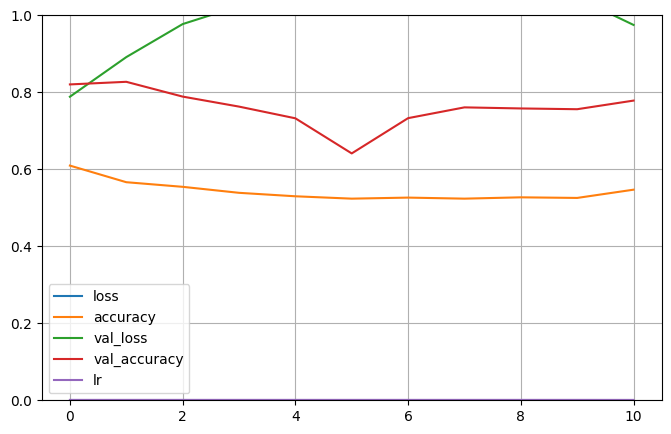

In [ ]:
pd.DataFrame(history_tfid.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [ ]:
model_opt2.evaluate(sparse_x_test, y_test_tf)

94/94 [==============================] - 1s 6ms/step - loss: 2.4413 - accuracy: 0.1950


[2.4413235187530518, 0.19499999284744263]

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.model_selection import KFold
from sklearn.ensemble import AdaBoostClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

cv = KFold(n_splits=10, shuffle=True, random_state=42)

In [ ]:
alldata_en = alldata[['content', 'category']]

**Preparing TFID vectors for OneVsRest Model**

In [ ]:
x_train_tf, x_test_tf, y_train_tf, y_test_tf = train_test_split(alldata_en['content'],
                                                                alldata_en['category'],
                                                                test_size = 0.3, random_state=42)

tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=10000)
tfidf_vectorizer.fit(x_train_tf)
x_train_tfid = tfidf_vectorizer.fit_transform(x_train_tf)
x_test_tfid = tfidf_vectorizer.transform(x_test_tf)

In [ ]:
#tree = DecisionTreeClassifier()
parameters = {
    'max_depth':[2, 4, 6, 8],
    'min_samples_split':[2, 5, 10],
    'min_samples_leaf':[2, 5, 10]
    }
#clftree = GridSearchCV(tree, parameters, cv=cv)
#clftree.fit(x_train_tfid, y_train_tf)
#besttree = clftree.best_estimator_
#DecisionTreeClassifier(max_depth=8, min_samples_leaf=5, min_samples_split=10)

In [ ]:
tree = DecisionTreeClassifier()

In [ ]:
parameters = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.1, 0.01, 0.001]
    }

ada_clf = AdaBoostClassifier(estimator=tree, algorithm="SAMME.R")


In [ ]:
grid_search = GridSearchCV(ada_clf, param_grid=parameters, cv=cv)

In [ ]:
grid_search.fit(x_train_tfid, y_train_tf)

GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=AdaBoostClassifier(estimator=DecisionTreeClassifier()),
             param_grid={'learning_rate': [0.1, 0.01, 0.001],
                         'n_estimators': [50, 100, 200]})

In [ ]:
ada_clf_tfid = grid_search.best_estimator_

In [ ]:
ovr = OneVsRestClassifier(ada_clf_tfid)

In [ ]:
ovr.fit(x_train_tfid, y_train_tf)

OneVsRestClassifier(estimator=AdaBoostClassifier(estimator=DecisionTreeClassifier(),
                                                 learning_rate=0.1,
                                                 n_estimators=200))

In [ ]:
ypreds_ovr = ovr.predict(x_test_tfid)

scorestree = cross_val_score(ovr, x_train_tfid, y_train_tf)
print("Cross-validation scores Tree: ", np.round(np.mean(scorestree),3))

Cross-validation scores Tree:  0.891


In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
cm_ovr = classification_report(y_test_tf, ypreds_ovr)
print(cm_ovr)

               precision    recall  f1-score   support

     business       0.98      0.83      0.90       591
    education       0.98      0.89      0.93       626
entertainment       0.98      0.91      0.94       610
       sports       0.93      0.91      0.92       584
   technology       0.72      0.97      0.83       589

     accuracy                           0.90      3000
    macro avg       0.92      0.90      0.90      3000
 weighted avg       0.92      0.90      0.90      3000



Text(0.5, 1.0, 'Confusion Matrix Model with Tfid representation Adaboost/OneVsRest model')

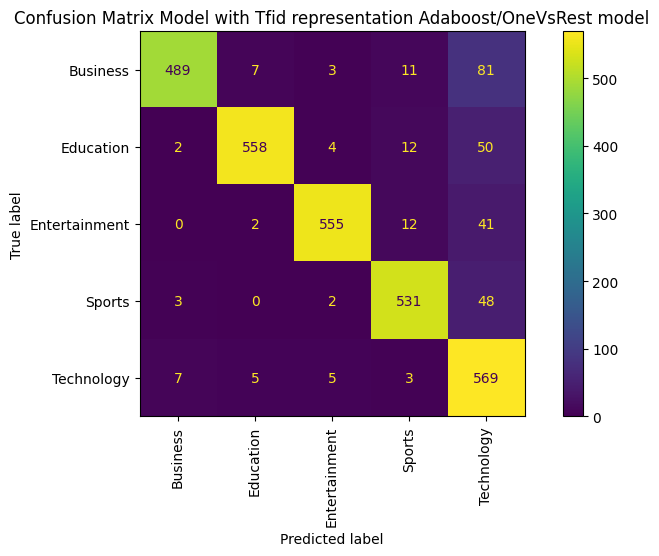

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
disp2 = ConfusionMatrixDisplay.from_predictions(y_test_tf, ypreds_ovr, ax=ax,
                                               xticks_rotation="vertical")
ax.xaxis.set_ticklabels(classnames.values())
ax.yaxis.set_ticklabels(classnames.values())
plt.title("Confusion Matrix Model with Tfid representation Adaboost/OneVsRest model")

### Using pretrained word embeddings


In [98]:
# Tokenize feature

from tf_keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

maxlen = 100
max_words = 10000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(feature)
sequences = tokenizer.texts_to_sequences(feature)

word_index = tokenizer.word_index

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(targets)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

Shape of data tensor: (10000, 100)
Shape of label tensor: (10000,)


In [99]:
VALIDATION_SPLIT = 0.25
TRAIN_SPLIT = 0.7

nb_training_samples = int(TRAIN_SPLIT * data.shape[0])
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

#Train/Test sets
x_train, x_test = data[:nb_training_samples], data[nb_training_samples:]
y_train, y_test_real = labels[:nb_training_samples], labels[nb_training_samples:]

# validation sets
x_valid = x_train[-nb_validation_samples:]
y_valid = y_train[-nb_validation_samples:]

In [23]:
print(y_train[0:10])
#print(type(y_valid))

['technology' 'education' 'entertainment' 'sports' 'entertainment'
 'business' 'sports' 'education' 'education' 'sports']


In [100]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(y_train)
y_train = encoder.transform(y_train)

In [101]:
y_valid = encoder.transform(y_valid)
y_test = encoder.transform(y_test_real)
y_test_coms = encoder.transform(y_test_real)

In [102]:
y_train = keras.utils.to_categorical(y_train)
y_valid = keras.utils.to_categorical(y_valid)
y_test = keras.utils.to_categorical(y_test)

In [103]:
print(y_train)

[[0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 ...
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]


### Model with Word embeddings


In [118]:
from keras.models import Sequential
from keras.layers import Embedding, Dense, Flatten, LSTM
from keras.layers import Conv1D, MaxPooling1D, Dropout

model = Sequential()
model.add(Embedding(input_dim=max_words,
                    output_dim=embedding_dim,
                    input_length = maxlen,
                    weights = [embedding_matrix],
                    trainable = False))
model.add(Conv1D(32, 7, activation = 'relu'))
model.add(MaxPooling1D(5))
model.add(Conv1D(32, 7, activation = 'relu'))
model.add(MaxPooling1D(5))
model.add(LSTM(32, recurrent_dropout=0.25, unroll=True))
model.add(Flatten())
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dropout(0.5))
model.add(Dense(5, activation = 'softmax'))

model.summary()
model.save("model.keras")

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_20 (Embedding)    (None, 100, 100)          1000000   
                                                                 
 conv1d_38 (Conv1D)          (None, 94, 32)            22432     
                                                                 
 max_pooling1d_38 (MaxPooli  (None, 18, 32)            0         
 ng1D)                                                           
                                                                 
 conv1d_39 (Conv1D)          (None, 12, 32)            7200      
                                                                 
 max_pooling1d_39 (MaxPooli  (None, 2, 32)             0         
 ng1D)                                                           
                                                                 
 lstm_18 (LSTM)              (None, 32)              

In [119]:
from gc import callbacks
model.compile(
    optimizer = keras.optimizers.Adam(),
    loss="categorical_crossentropy",
    metrics=['accuracy']
)

In [120]:
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=100,
                    validation_data = (x_valid, y_valid),
                    callbacks = my_callbacks)

Epoch 1/10
70/70 [==============================] - 4s 18ms/step - loss: 1.4727 - accuracy: 0.3339 - val_loss: 0.8256 - val_accuracy: 0.8172 - lr: 0.0010
Epoch 2/10
70/70 [==============================] - 1s 15ms/step - loss: 0.6785 - accuracy: 0.7674 - val_loss: 0.2336 - val_accuracy: 0.9220 - lr: 0.0010
Epoch 3/10
70/70 [==============================] - 1s 13ms/step - loss: 0.3712 - accuracy: 0.8906 - val_loss: 0.1961 - val_accuracy: 0.9364 - lr: 0.0010
Epoch 4/10
70/70 [==============================] - 1s 15ms/step - loss: 0.3035 - accuracy: 0.9144 - val_loss: 0.1801 - val_accuracy: 0.9424 - lr: 0.0010
Epoch 5/10
70/70 [==============================] - 1s 13ms/step - loss: 0.2534 - accuracy: 0.9301 - val_loss: 0.1371 - val_accuracy: 0.9584 - lr: 0.0010
Epoch 6/10
70/70 [==============================] - 1s 16ms/step - loss: 0.2236 - accuracy: 0.9439 - val_loss: 0.1062 - val_accuracy: 0.9704 - lr: 0.0010
Epoch 7/10
70/70 [==============================] - 1s 18ms/step - loss: 0.1

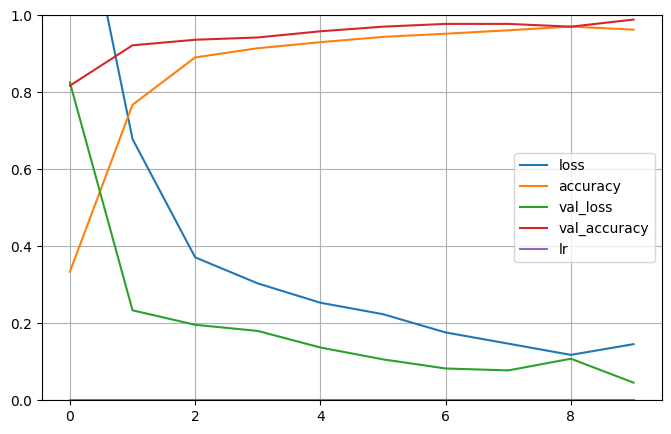

In [121]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [122]:
model.evaluate(x_test, y_test)

94/94 [==============================] - 1s 5ms/step - loss: 0.2549 - accuracy: 0.9377


[0.2548697590827942, 0.937666654586792]

In [123]:
class_names = targets.unique()
class_names

array(['education', 'business', 'entertainment', 'sports', 'technology'],
      dtype=object)

In [124]:
X_new = x_test[:10]
y_pred = np.argmax(model.predict(X_new), axis=1)
print(np.array(class_names)[y_pred])

y_preds = np.argmax(model.predict(x_test), axis=1)

1/1 [==============================] - 0s 363ms/step
['entertainment' 'technology' 'education' 'entertainment' 'entertainment'
 'sports' 'technology' 'education' 'entertainment' 'entertainment']
94/94 [==============================] - 0s 3ms/step


In [125]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
cm = classification_report(y_test_coms, y_preds)
print(cm)

              precision    recall  f1-score   support

           0       0.94      0.90      0.92       587
           1       0.97      0.94      0.95       587
           2       0.96      0.97      0.96       622
           3       0.96      0.96      0.96       601
           4       0.87      0.92      0.89       603

    accuracy                           0.94      3000
   macro avg       0.94      0.94      0.94      3000
weighted avg       0.94      0.94      0.94      3000



Text(0.5, 1.0, 'Confusion Matrix Model with pretrained word embeddings')

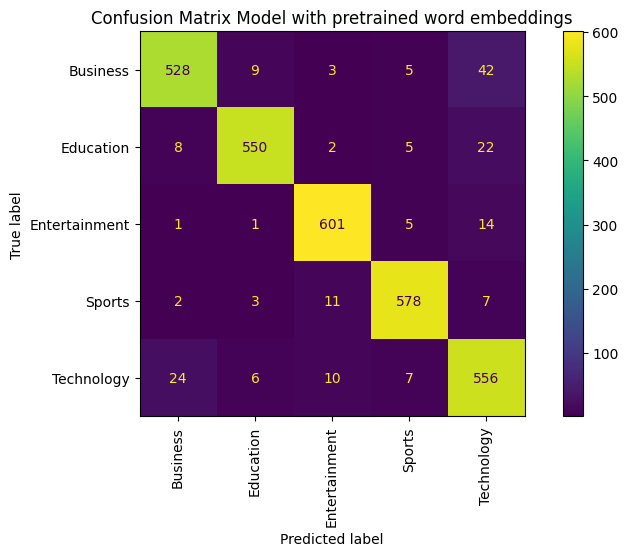

In [126]:
fig, ax = plt.subplots(figsize=(10, 5))
disp = ConfusionMatrixDisplay.from_predictions(y_test_coms, y_preds, ax=ax,
                                               xticks_rotation="vertical")
ax.xaxis.set_ticklabels(classnames.values())
ax.yaxis.set_ticklabels(classnames.values())
plt.title("Confusion Matrix Model with pretrained word embeddings")

In [127]:
import pickle

In [128]:
pickle.dump(model, open('modelreal.pkl', 'wb'))

In [129]:
pickled_model = pickle.load(open('modelreal.pkl', 'rb'))

In [131]:
ypred = np.argmax(pickled_model.predict(x_test), axis=1)

94/94 [==============================] - 0s 3ms/step


In [132]:
print(np.array(class_names)[y_pred])

['entertainment' 'technology' 'education' 'entertainment' 'entertainment'
 'sports' 'technology' 'education' 'entertainment' 'entertainment']
